In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
np.random.seed(42)
DATASET_SIZE = 500
date_range = pd.date_range(start='2023-01-01', periods=DATASET_SIZE, freq='D')

#trend component
trend = np.linspace(10, 20, DATASET_SIZE)

#seasonality component
seasonality = 3 * np.sin(2 * np.pi * date_range.dayofyear / 7)

#random gaussian noise
noise = np.random.normal(loc=0, scale=1, size=DATASET_SIZE)

#time series = noise + seasonality + trend
data = trend + seasonality + noise
df = pd.Series(data, index=date_range, name='target')
df = pd.DataFrame(df)

# 1. Advanced Forecast Methods

# 1.1. Tree Algorithms

Tree algorithms can be used to model time series data, but they need the data to be prepared in a special way. Instead of using raw time series values, you need to create features. These features can include past values (lag features), external information (like weather or holidays), or statistical summaries (like moving averages). Creating more useful features from the existing data can help the model make better predictions.

One advantage of using tree algorithms for time series is that they don’t require the data to be weakly stationary. This means you often don’t need to apply preprocessing steps like differencing or detrending.

Here is an example of modeling tree algorithms for time series using `LightGBM`. Besides lag features, time data and exponential weigted mean are used for prediction.

In [3]:
lgb_df = df.copy()

lgb_df["first_shift"] = lgb_df["target"].shift(1)
lgb_df["second_shift"] = lgb_df["target"].shift(2)
lgb_df["third_shift"] = lgb_df["target"].shift(3)
lgb_df["fourth_shift"] = lgb_df["target"].shift(4)
lgb_df["fifth_shift"] = lgb_df["target"].shift(5)
lgb_df["sixth_shift"] = lgb_df["target"].shift(6)
lgb_df["seventh_shift"] = lgb_df["target"].shift(7)
lgb_df["day_of_week"] = lgb_df.index.dayofweek
lgb_df["day_of_month"] = lgb_df.index.day
lgb_df["month"] = lgb_df.index.month
lgb_df["ewm_mean_7"] = lgb_df["target"].ewm(span=7).mean()
lgb_df["ewm_std_7"] = lgb_df["target"].ewm(span=7).std()
lgb_df = lgb_df.dropna()

X = lgb_df.drop(columns=["target"])
y = lgb_df["target"]
X_trn, X_test, y_trn, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_trn, y_trn, test_size=0.2, random_state=42,shuffle=False)

In [4]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

lgb_params = {
    'objective': 'regression',
    'random_state': 42,
    'verbose': -1}

lgb_model = lgb.train(lgb_params,
                      lgb_train,
                      valid_sets = lgb_valid,
                      num_boost_round = 1000,
                      callbacks=[lgb.early_stopping(10)])


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 1.9764


In [5]:
train_preds = pd.Series(lgb_model.predict(X_train), index=X_train.index, name='target')
print('Train MAE:', mean_absolute_error(y_train, train_preds))
print('Train MSE:', mean_squared_error(y_train, train_preds))
print()

test_preds = pd.Series(lgb_model.predict(X_test), index=X_test.index, name='target')
print('Validation MAE:', mean_absolute_error(y_test, test_preds))
print('Validation MSE:', mean_squared_error(y_test, test_preds))

Train MAE: 0.3935143499378989
Train MSE: 0.24689714917321673

Validation MAE: 1.962639274735711
Validation MSE: 5.750030239043836


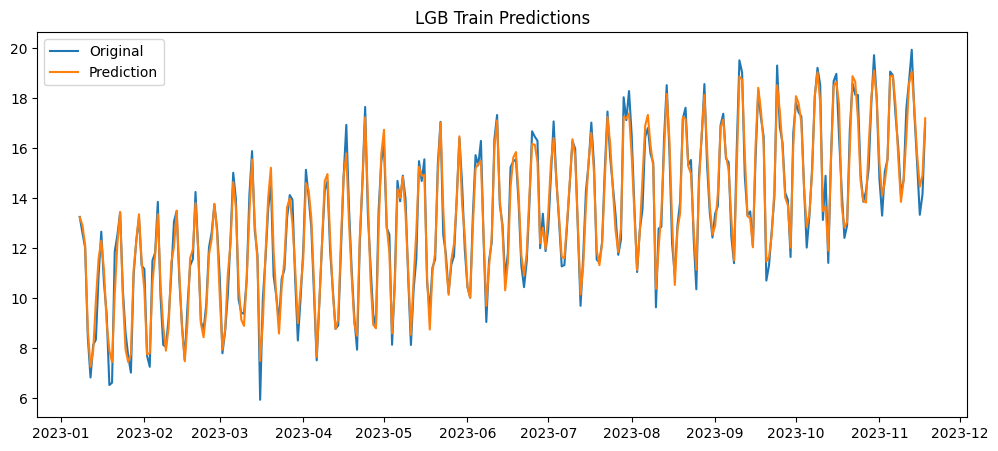

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(y_train, label="Original")
plt.plot(train_preds, label="Prediction")
plt.legend()
plt.title("LGB Train Predictions")
plt.show()

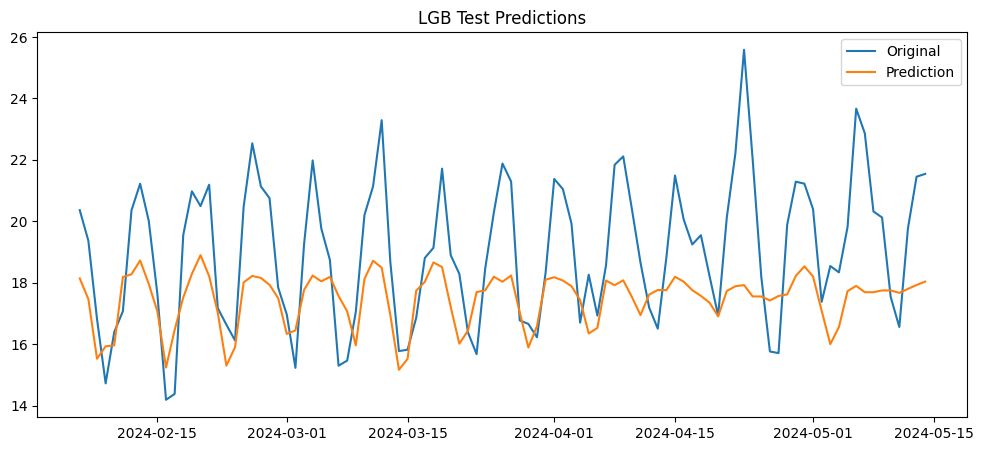

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Original")
plt.plot(test_preds, label="Prediction")
plt.legend()
plt.title("LGB Test Predictions")
plt.show()

## 1.2. Neural Networks

Neural networks can model complex time series patterns very well. But one downside is that their performance depends a lot on how you set the input features and model parameters. So, it might take some time and trial and error to get good results.

In [8]:
ss = StandardScaler()

df_train = ss.fit_transform(df.iloc[:300].copy())
df_validation = ss.transform(df.iloc[300:400].copy())
df_test = ss.transform(df.iloc[400:].copy())
sequence_length = 15

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = df_train[:-sequence_length],
    targets = df_train[sequence_length:],
    sequence_length = sequence_length,
    sequence_stride = 1,
    shuffle = False,
    )

validation_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = df_validation[:-sequence_length],
    targets = df_validation[sequence_length:],
    sequence_length = sequence_length,
    sequence_stride = 1,
    shuffle = False,
    )

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = df_test[:-sequence_length],
    targets = df_test[sequence_length:],
    sequence_length = sequence_length,
    sequence_stride = 1,
    shuffle = False,
    )

### 1.2.1. Long Short Term Memory (LSTM) Networks

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

lstm_network = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,return_sequences = True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(10,activation = "selu"),
    tf.keras.layers.Dense(1)
])

lstm_network.compile(optimizer='adam', loss='mae')
lstm_network.fit(train_dataset,
                 epochs=500,
                 validation_data=validation_dataset,
                 callbacks = tf.keras.callbacks.EarlyStopping(patience=10),
                 verbose=0
                 )

In [10]:
lstm_train_preds = ss.inverse_transform(lstm_network.predict(train_dataset)).ravel()
lstm_test_preds = ss.inverse_transform(lstm_network.predict(test_dataset)).ravel()

train_cutoff = lstm_train_preds.shape[0]
test_cutoff = lstm_test_preds.shape[0]

y_train = df.iloc[:train_cutoff]
y_test = df.iloc[-test_cutoff:]

print('Train MAE:', mean_absolute_error(y_train, lstm_train_preds))
print('Train MSE:', mean_squared_error(y_train, lstm_train_preds))
print()
print('Validation MAE:', mean_absolute_error(y_test, lstm_test_preds))
print('Validation MSE:', mean_squared_error(y_test, lstm_test_preds))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Train MAE: 1.5986218452453613
Train MSE: 3.587146282196045

Validation MAE: 1.898201584815979
Validation MSE: 5.508999347686768


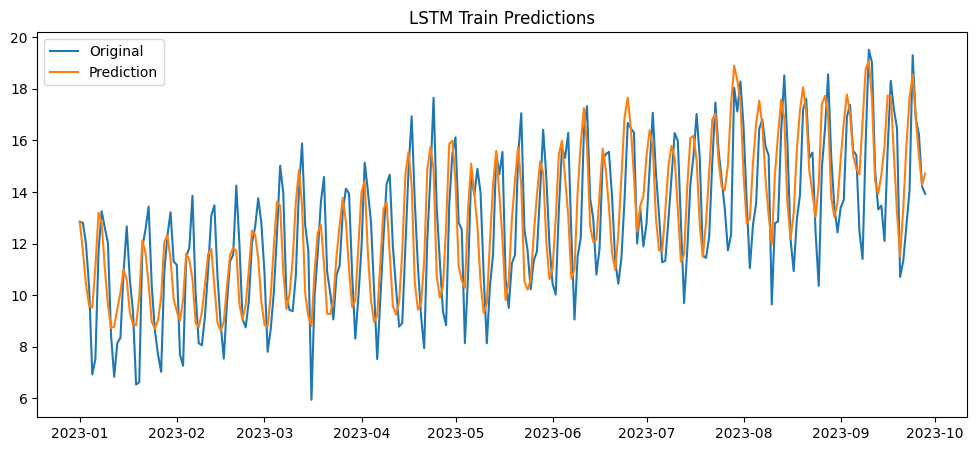

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(y_train, label="Original")
plt.plot(y_train.index,lstm_train_preds, label="Prediction")
plt.legend()
plt.title("LSTM Train Predictions")
plt.show()

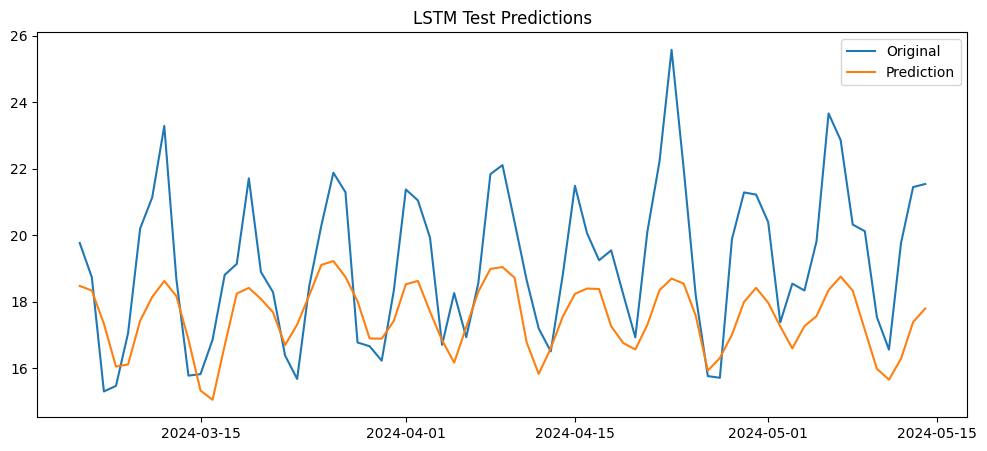

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Original")
plt.plot(y_test.index,lstm_test_preds, label="Prediction")
plt.legend()
plt.title("LSTM Test Predictions")
plt.show()

### 1.2.2. GRU Networks

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

gru_network = tf.keras.Sequential([
    tf.keras.layers.GRU(64,return_sequences = True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(10,activation = "selu"),
    tf.keras.layers.Dense(1)
])

gru_network.compile(optimizer='adam', loss='mae')
gru_network.fit(train_dataset,
                 epochs=500,
                 validation_data=validation_dataset,
                 callbacks = tf.keras.callbacks.EarlyStopping(patience=10),
                 verbose=0
                 )

gru_train_preds = ss.inverse_transform(gru_network.predict(train_dataset)).ravel()
gru_test_preds = ss.inverse_transform(gru_network.predict(test_dataset)).ravel()

train_cutoff = gru_train_preds.shape[0]
test_cutoff = gru_test_preds.shape[0]

y_train = df.iloc[:train_cutoff]
y_test = df.iloc[-test_cutoff:]

print('Train MAE:', mean_absolute_error(y_train, gru_train_preds))
print('Train MSE:', mean_squared_error(y_train, gru_train_preds))
print()
print('Validation MAE:', mean_absolute_error(y_test, gru_test_preds))
print('Validation MSE:', mean_squared_error(y_test, gru_test_preds))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Train MAE: 1.7944307327270508
Train MSE: 4.532359600067139

Validation MAE: 1.60482656955719
Validation MSE: 3.917266368865967


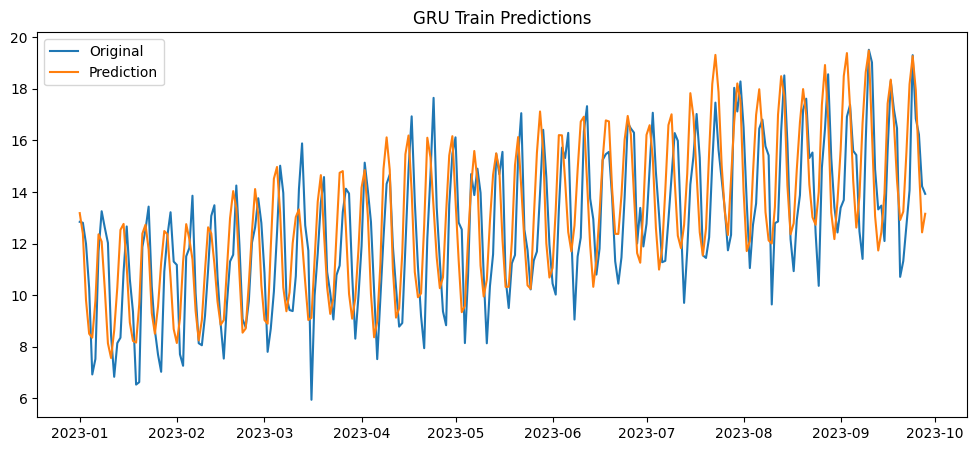

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(y_train, label="Original")
plt.plot(y_train.index,gru_train_preds, label="Prediction")
plt.legend()
plt.title("GRU Train Predictions")
plt.show()

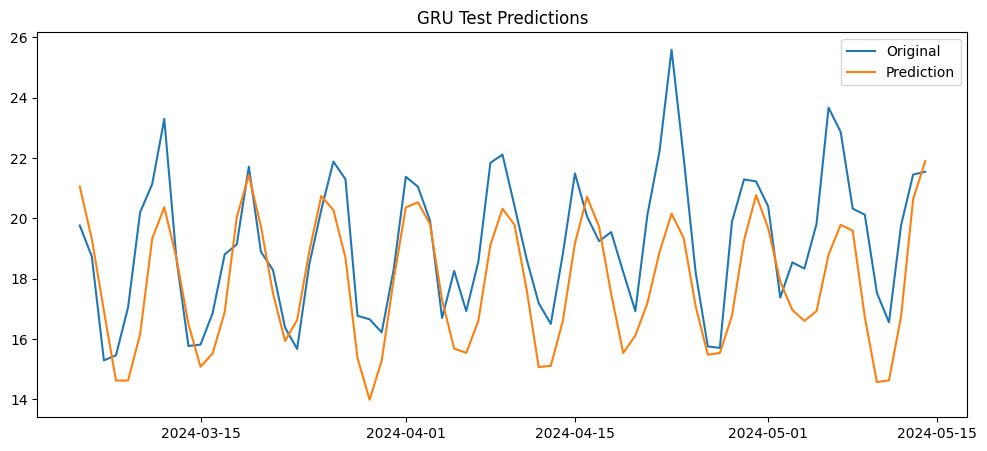

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Original")
plt.plot(y_test.index,gru_test_preds, label="Prediction")
plt.legend()
plt.title("GRU Test Predictions")
plt.show()

### 1.2.3. RNN Networks

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

rnn_network = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64,return_sequences = True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(10,activation = "selu"),
    tf.keras.layers.Dense(1)
])

rnn_network.compile(optimizer='adam', loss='mae')
rnn_network.fit(train_dataset,
                 epochs=500,
                 validation_data=validation_dataset,
                 callbacks = tf.keras.callbacks.EarlyStopping(patience=10),
                 verbose=0
                 )

rnn_train_preds = ss.inverse_transform(rnn_network.predict(train_dataset)).ravel()
rnn_test_preds = ss.inverse_transform(rnn_network.predict(test_dataset)).ravel()

train_cutoff = rnn_train_preds.shape[0]
test_cutoff = rnn_test_preds.shape[0]

y_train = df.iloc[:train_cutoff]
y_test = df.iloc[-test_cutoff:]

print('Train MAE:', mean_absolute_error(y_train, rnn_train_preds))
print('Train MSE:', mean_squared_error(y_train, rnn_train_preds))
print()
print('Validation MAE:', mean_absolute_error(y_test, rnn_test_preds))
print('Validation MSE:', mean_squared_error(y_test, rnn_test_preds))

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Train MAE: 2.018112897872925
Train MSE: 5.573760986328125

Validation MAE: 3.7497425079345703
Validation MSE: 16.257854461669922


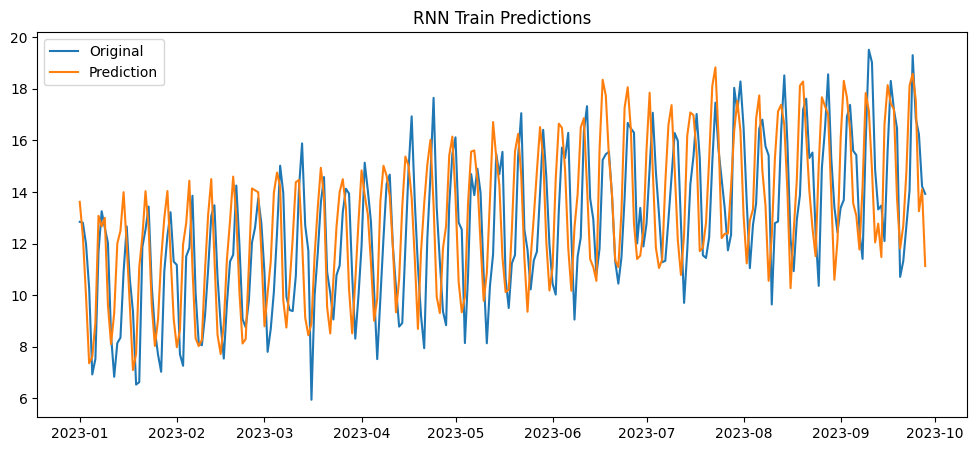

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(y_train, label="Original")
plt.plot(y_train.index,rnn_train_preds, label="Prediction")
plt.legend()
plt.title("RNN Train Predictions")
plt.show()

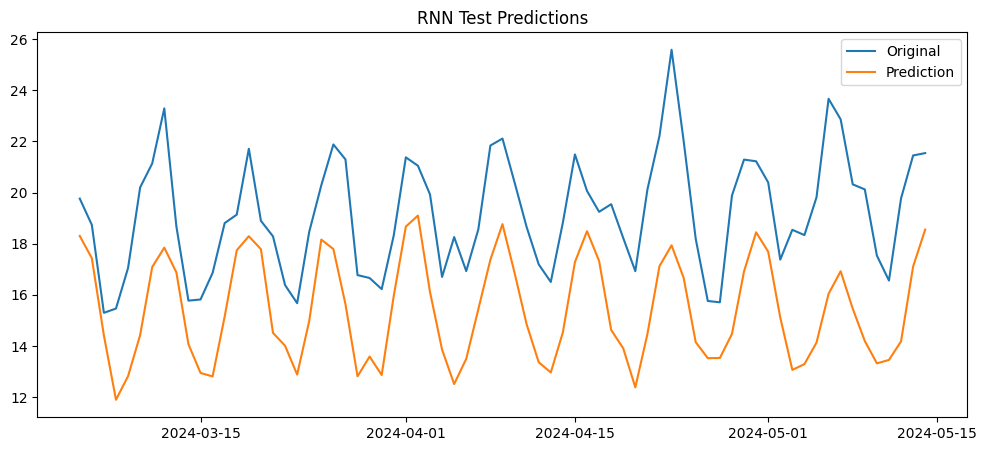

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Original")
plt.plot(y_test.index,rnn_test_preds, label="Prediction")
plt.legend()
plt.title("RNN Test Predictions")
plt.show()